# Vector data cube blog post part 1
What are vector data cubes and how can they be integrated into scientific workflows? 
Example workflow to demoonstrate usage

## Example: Creating vector data cube from ERA5 reanalysis data for cities in Europe
We have ERA5 gridded reanalysis data, would like to extract only area's of interest, so that rather than (x,y,time) cube with data variables we have (cities, time) cube with data variables

Steps:
1. Start with gridded ERA5 data
2. ID points of interest (cities)
3. Interpolate xarray gridded dataset to points 

In [1]:
import fsspec
import xarray as xr
from datasets import load_dataset
import pandas as pd
import geopandas as gpd
import cf_xarray
import xvec
import numpy as np
import shapely

In [2]:

fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/ar/')


['gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg_der

In [3]:
era5_ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2',
    chunks={'time': 48},
    consolidated=True,
)

/home/emmamarshall/miniconda/envs/arraylake/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [4]:
print(f'size: {era5_ds.nbytes / (1024 ** 4)} TiB')

size: 81.35224620026929 TiB


In [5]:
era5_ds.longitude.max()

<xarray.DataArray 'longitude' ()> Size: 4B
array(359.75, dtype=float32)

## Cities
load city data to extract coords
- subsetting to Spain for now (plug in desired list of cities/points later)

In [6]:
cities = load_dataset('jamescalam/world-cities-geo',split='train')

Repo card metadata block was not found. Setting CardData to empty.


In [7]:
cities_df = pd.DataFrame({'city':cities['city'],
                          'country':cities['country'],
                          'region':cities['region'],
                          'latitude':cities['latitude'],
                          'longitude':cities['longitude'],
                          'continent':cities['continent'],
                         'x':cities['x'], 'y':cities['y'], 'z':cities['z']})

In [9]:
def lon_360(row):
    new_lon = ((360 + (row['longitude'] % 360)) % 360)
    return new_lon

Convet longitude values to 0,360 to match era5

In [25]:
cities_df['lon_360'] = cities_df.apply(lon_360, axis=1)

In [26]:
cities_eur = cities_df.loc[cities_df['continent'] == 'Europe']

In [27]:
cities_eur = gpd.GeoDataFrame(
    cities_eur,
    geometry = gpd.points_from_xy(cities_eur.longitude, cities_eur.latitude),
    crs = 'EPSG:4326'
)

In [28]:
cities_sp = cities_eur.loc[cities_eur['country'] == 'Spain']

In [14]:
#lat = cities_sp.latitude.to_list()
#lon = cities_sp.lon_360.to_list()

In [29]:
cities_sp.head()

,city,country,region,latitude,longitude,continent,x,y,z,lon_360,geometry
7858,Madrid,Spain,Southern Europe,40.416502,-3.702564,Europe,4840.446633,-313.235177,4130.569103,356.297436,POINT (-3.70256 40.41650)
7859,Barcelona,Spain,Southern Europe,41.388787,2.158985,Europe,4776.389107,180.066254,4212.282545,2.158985,POINT (2.15899 41.38879)
7860,Valencia,Spain,Southern Europe,39.469752,-0.377387,Europe,4918.052224,-32.393919,4049.858510,359.622613,POINT (-0.37739 39.46975)
7861,Sevilla,Spain,Southern Europe,37.377222,-5.986944,Europe,5035.139658,-528.054516,3867.579095,354.013056,POINT (-5.98694 37.37722)
7862,Zaragoza,Spain,Southern Europe,41.656064,-0.877340,Europe,4759.522354,-72.885731,4234.533698,359.122660,POINT (-0.87734 41.65606)


In [30]:
#create xr.data array from cities geodf
geom = cities_sp['geometry']

data = cities_sp['city']

spain_da = xr.DataArray(
    data,
    coords={'geom': geom},
    dims='geom',
)

In [31]:
spain_da

<xarray.DataArray 'city' (geom: 99)> Size: 792B
array(['Madrid', 'Barcelona', 'Valencia', 'Sevilla', 'Zaragoza', 'Malaga',
       'Murcia', 'Las Palmas de Gran Canaria', 'Palma', 'Bilbao',
       'Valladolid', 'Cordoba', 'Alacant', 'Vigo', 'Gijon', 'Eixample',
       'A Coruna', 'Granada', 'Vitoria-Gasteiz', 'Santa Cruz de Tenerife',
       'Sant Marti', 'Badalona', 'Elx', 'Oviedo', 'Mostoles', 'Cartagena',
       'Terrassa', 'Fuenlabrada', 'Sabadell', 'Alcala de Henares',
       'Jerez de la Frontera', 'Pamplona', 'San Sebastian', 'Santander',
       'Leganes', 'Almeria', 'Castello de la Plana', 'Burgos',
       'Nou Barris', 'Salamanca', 'Getafe', 'Alcorcon', 'Albacete',
       'Huelva', 'Logrono', 'Badajoz', 'La Laguna', 'Leon', 'Cadiz',
       'Tarragona', 'Lleida', 'Marbella', 'Santa Coloma de Gramenet',
       'Jaen', 'Mataro', 'Dos Hermanas', 'Ciutat Vella', 'Algeciras',
       'Delicias', 'Torrejon de Ardoz', 'Ourense', 'Alcobendas', 'Reus',
       'Telde', 'Barakaldo', 'Santiago de Compostela', 'Lugo',
       'San Fernando', 'Parla', 'Girona', 'Caceres', 'Lorca',
       'Cornella de Llobregat', 'Aviles', 'Coslada', 'Algorta',
       'El Puerto de Santa Maria', 'Palencia', 'Talavera de la Reina',
       'Pontevedra', 'Pozuelo de Alarcon', 'Torrevieja', 'Ferrol',
       'Ceuta', 'Toledo', 'Guadalajara', 'Torrent', 'Orihuela',
       'Chiclana de la Frontera', 'Manresa', 'Las Rozas de Madrid',
       'Ciudad Real', 'Rubi', 'Melilla', 'Sant Cugat del Valles',
       'Benidorm', 'El Ejido', 'Zamora', 'Ponferrada'], dtype=object)
Coordinates:
  * geom     (geom) object 792B POINT (-3.7025642 40.4165021) ... POINT (-6.5...

In [32]:
#use xvec to convert to geomindex
spain_da = spain_da.xvec.set_geom_indexes('geom',crs=4326)

In [33]:
spain_da

<xarray.DataArray 'city' (geom: 99)> Size: 792B
array(['Madrid', 'Barcelona', 'Valencia', 'Sevilla', 'Zaragoza', 'Malaga',
       'Murcia', 'Las Palmas de Gran Canaria', 'Palma', 'Bilbao',
       'Valladolid', 'Cordoba', 'Alacant', 'Vigo', 'Gijon', 'Eixample',
       'A Coruna', 'Granada', 'Vitoria-Gasteiz', 'Santa Cruz de Tenerife',
       'Sant Marti', 'Badalona', 'Elx', 'Oviedo', 'Mostoles', 'Cartagena',
       'Terrassa', 'Fuenlabrada', 'Sabadell', 'Alcala de Henares',
       'Jerez de la Frontera', 'Pamplona', 'San Sebastian', 'Santander',
       'Leganes', 'Almeria', 'Castello de la Plana', 'Burgos',
       'Nou Barris', 'Salamanca', 'Getafe', 'Alcorcon', 'Albacete',
       'Huelva', 'Logrono', 'Badajoz', 'La Laguna', 'Leon', 'Cadiz',
       'Tarragona', 'Lleida', 'Marbella', 'Santa Coloma de Gramenet',
       'Jaen', 'Mataro', 'Dos Hermanas', 'Ciutat Vella', 'Algeciras',
       'Delicias', 'Torrejon de Ardoz', 'Ourense', 'Alcobendas', 'Reus',
       'Telde', 'Barakaldo', 'Santiago de Compostela', 'Lugo',
       'San Fernando', 'Parla', 'Girona', 'Caceres', 'Lorca',
       'Cornella de Llobregat', 'Aviles', 'Coslada', 'Algorta',
       'El Puerto de Santa Maria', 'Palencia', 'Talavera de la Reina',
       'Pontevedra', 'Pozuelo de Alarcon', 'Torrevieja', 'Ferrol',
       'Ceuta', 'Toledo', 'Guadalajara', 'Torrent', 'Orihuela',
       'Chiclana de la Frontera', 'Manresa', 'Las Rozas de Madrid',
       'Ciudad Real', 'Rubi', 'Melilla', 'Sant Cugat del Valles',
       'Benidorm', 'El Ejido', 'Zamora', 'Ponferrada'], dtype=object)
Coordinates:
  * geom     (geom) object 792B POINT (-3.7025642 40.4165021) ... POINT (-6.5...
Indexes:
    geom     GeometryIndex (crs=EPSG:4326)

In [34]:
spain_ds = spain_da.to_dataset()

In [35]:
spain_ds['lat'] = ('geom',cities_sp['latitude'])
spain_ds['lon'] = ('geom',cities_sp['lon_360'])

In [36]:
spain_ds.xindexes

Indexes:
    geom     GeometryIndex (crs=EPSG:4326)

In [37]:
spain_ds

<xarray.Dataset> Size: 3kB
Dimensions:  (geom: 99)
Coordinates:
  * geom     (geom) object 792B POINT (-3.7025642 40.4165021) ... POINT (-6.5...
Data variables:
    city     (geom) object 792B 'Madrid' 'Barcelona' ... 'Zamora' 'Ponferrada'
    lat      (geom) float64 792B 40.42 41.39 39.47 37.38 ... 36.78 41.5 42.55
    lon      (geom) float64 792B 356.3 2.159 359.6 354.0 ... 357.2 354.2 353.4
Indexes:
    geom     GeometryIndex (crs=EPSG:4326)

## ERA5
- model levels: correspond to vertical slice / elevation; [docs](https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions)

In [38]:
era5_ds0 = era5_ds.sel(level=0) #take just near-surface mdel level

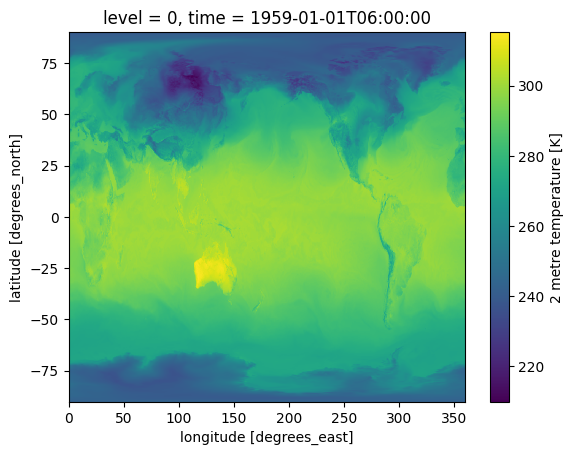

In [39]:
era5_ds0.isel(time=1)['2m_temperature'].plot();


In [40]:
era5_spain = era5_ds0.interp(latitude=spain_ds.lat, longitude=spain_ds.lon)

In [42]:
era5_spain['city_name'] = spain_ds['city']

In [50]:
era5_spain = era5_spain.assign_coords({'city_name':era5_spain['city_name']})

In [43]:
era5_spain.isel(time=slice(-1), geom=slice(0,5))['2m_temperature']

<xarray.DataArray '2m_temperature' (time: 92043, geom: 5)> Size: 2MB
dask.array<getitem, shape=(92043, 5), dtype=float32, chunksize=(48, 5), chunktype=numpy.ndarray>
Coordinates:
    level      int64 8B 0
  * time       (time) datetime64[ns] 736kB 1959-01-01 ... 2021-12-31T12:00:00
    latitude   (geom) float64 40B 40.42 41.39 39.47 37.38 41.66
    longitude  (geom) float64 40B 356.3 2.159 359.6 354.0 359.1
  * geom       (geom) object 40B POINT (-3.7025642 40.4165021) ... POINT (-0....
Indexes:
    geom     GeometryIndex (crs=EPSG:4326)
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [44]:
era5_spain.isel(geom=slice(0,10))

<xarray.Dataset> Size: 67MB
Dimensions:                                           (time: 92044, geom: 10)
Coordinates:
    level                                             int64 8B 0
  * time                                              (time) datetime64[ns] 736kB ...
    latitude                                          (geom) float64 80B 40.4...
    longitude                                         (geom) float64 80B 356....
  * geom                                              (geom) object 80B POINT...
Data variables: (12/33)
    10m_u_component_of_wind                           (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    10m_v_component_of_wind                           (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    2m_temperature                                    (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (geom) float32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (geom) float32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    geopotential                                      (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (geom) float32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    type_of_low_vegetation                            (geom) float32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    u_component_of_wind                               (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    v_component_of_wind                               (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    vertical_velocity                                 (time, geom) float32 4MB dask.array<chunksize=(48, 10), meta=np.ndarray>
    city_name                                         (geom) object 80B 'Madr...
Indexes:
    geom     GeometryIndex (crs=EPSG:4326)